[2024-08-23 Fiddler](https://thefiddler.substack.com/p/round-round-get-a-round-i-get-a-round)
====================
Another [song](https://www.youtube.com/watch?v=0u8teXR8VE4) option.

The sums could be 0, 1, or 2.

The sum of the rounded numbers is 0 when both numbers are less than 0.5.  It's 1 when one number
is less than 0.5 and the other is greater than 0.5.  It's 2 when both numbers are greater than 0.5.

The probability that both numbers are less than 0.5 and their rounded sum is 0 is

In [1]:
%display latex
x, y = var('x,y')
integral(integral(1,y,0,1/2-x),x,0,1/2)

1/8

By symmetry, the probability that both numbers are greater than 0.5 and their rounded sum is 2 is
also 1/8.

The probability that one number is less than 0.5 and the other is greater than 0.5 is
1/2, and their rounded sum is always 1.

So the probability that the sum of the rounded numbers is equal to the rounded sum is 3/4.

### Simulation

In [2]:
import random
import queue
import threading
from os import cpu_count

def simulate(label,n_trials,trial,rand):
    def simulate_1(n_trials,trial,rand,q):
        count = 0
        for i in range(n_trials):
            if trial(rand):
                count += 1
        q.put(count)
    n_cpu = cpu_count()
    q = queue.Queue()
    for i in range(n_cpu):
        threading.Thread(target=simulate_1,args=(n_trials,trial,random.Random(rand.getrandbits(64)),q)).start()
    count = 0
    for i in range(n_cpu):
        count += q.get()
    print(f"{label}{numerical_approx(count/(n_cpu*n_trials))}")

In [3]:
def trial(r):
    x = r.random()
    y = r.random()
    return round(x) + round(y) == round(x+y)

rand = random.Random(int(20240823))
simulate("", 20000, trial, rand)

0.749312500000000


Looks like good agreement.

My attempt at using multiple threads didn't result in any speedup
and I couldn't figure out how to use `multiprocessing.Process`, so I'll
probably go back to using Go for simulations in the future.

Extra credit
------------
When there are $N$ numbers, the sum of the rounded numbers is $n$ when there are $n$ numbers
greater than 0.5 and $N-n$ numbers less than 0.5.

The probability that there are $n$ numbers greater than 0.5 and $N-n$ numbers less than 0.5
is $\binom N n/2^N$.

The sum of the numbers is at least $n/2$.  After subtracting 0.5 from the numbers greater
than 0.5, there are $N$ random numbers uniformly between 0 and 0.5, and if their sum is
between $(n-1)/2$ and $(n+1)/2$, the sum of the original numbers will round to $n$.

The probability that the sum of $N$ random numbers between 0 and 0.5 is between $(n-1)/2$
and $(n+1)/2$ is the same as the probability that the sum of $N$ random numbers between 0
and 1 is between $n-1$ and $n+1$, and the probability distribution of that sum is the
[Irwin-Hall distribution](https://en.wikipedia.org/wiki/Irwin–Hall_distribution).

The probability that the sum is between $n$ and $n+1$ is

In [4]:
j,N,n = var('j,N,n')
assume(N > 0)
fx(x,n,N) = 1/factorial(N-1)*sum((-1)^j*binomial(N,j)*(x-j)^(N-1),j,0,n)
f(n,N) = integral(fx(x,n,N),x,n,n+1)
f

(n, N) |--> (sum((-1)^j*(-j + n + 1)^N*binomial(N, j), j, 0, n)/N - sum((-1)^j*(-j + n)^N*binomial(N, j), j, 0, n)/N)/factorial(N - 1)

Checking against the [special cases](https://en.wikipedia.org/wiki/Irwin–Hall_distribution#Special_cases),

In [5]:
for i in [1..5]:
    show([(fx(x,j,i)*factorial(i-1)).simplify_full() for j in [-1..i]])

[0, 1, 0]

[0, x, -x + 2, 0]

[0, x^2, -2*x^2 + 6*x - 3, x^2 - 6*x + 9, 0]

[0,
 x^3,
 -3*x^3 + 12*x^2 - 12*x + 4,
 3*x^3 - 24*x^2 + 60*x - 44,
 -x^3 + 12*x^2 - 48*x + 64,
 0]

[0,
 x^4,
 -4*x^4 + 20*x^3 - 30*x^2 + 20*x - 5,
 6*x^4 - 60*x^3 + 210*x^2 - 300*x + 155,
 -4*x^4 + 60*x^3 - 330*x^2 + 780*x - 655,
 x^4 - 20*x^3 + 150*x^2 - 500*x + 625,
 0]

So the probability that the sum of the rounded numbers and the rounded sum are both $n$ is

In [6]:
p(n,N) = binomial(N,n)/2^N*(f(n-1,N)+f(n,N))
p

(n, N) |--> ((sum((-1)^j*(-j + n + 1)^N*binomial(N, j), j, 0, n)/N - sum((-1)^j*(-j + n)^N*binomial(N, j), j, 0, n)/N)/factorial(N - 1) + (sum((-1)^j*(-j + n)^N*binomial(N, j), j, 0, n - 1)/N - sum((-1)^j*(-j + n - 1)^N*binomial(N, j), j, 0, n - 1)/N)/factorial(N - 1))*binomial(N, n)/2^N

Adding them up,

In [7]:
P(N) = sum(p(n,N),n,0,N)
P

N |--> sum(binomial(N, n)*sum((-1)^j*(-j + n + 1)^N*binomial(N, j), j, 0, n) + binomial(N, n)*sum((-1)^j*(-j + n)^N*binomial(N, j), j, 0, n - 1) - binomial(N, n)*sum((-1)^j*(-j + n)^N*binomial(N, j), j, 0, n) - binomial(N, n)*sum((-1)^j*(-j + n - 1)^N*binomial(N, j), j, 0, n - 1), n, 0, N)/(2^N*N*factorial(N - 1))

In [8]:
%display plain
P

N |--> sum(binomial(N, n)*sum((-1)^j*(-j + n + 1)^N*binomial(N, j), j, 0, n) + binomial(N, n)*sum((-1)^j*(-j + n)^N*binomial(N, j), j, 0, n - 1) - binomial(N, n)*sum((-1)^j*(-j + n)^N*binomial(N, j), j, 0, n) - binomial(N, n)*sum((-1)^j*(-j + n - 1)^N*binomial(N, j), j, 0, n - 1), n, 0, N)/(2^N*N*factorial(N - 1))

Manually cleaning up the expression,

$$ P(N) = \frac{1}{2^NN!} \sum_{n=0}^{N} \binom N n\left(
(-1)^n\binom N n + \sum_{j=0}^{n-1}(-1)^j\binom N j\left((n-j+1)^N - (n-j-1)^N\right)
\right) $$

In [9]:
PP(N) = 1/(2^N*factorial(N))*sum(binomial(N,n)
                                 *((-1)^n*binomial(N,n)
                                   + sum((-1)^j*binomial(N,j)*((n-j+1)^N-(n-j-1)^N),
                                         j,0,n-1)),
                                 n,0,N)
PP

N |--> sum((-1)^n*binomial(N, n)^2 + sum((-1)^j*(-j + n + 1)^N*binomial(N, j)*binomial(N, n) - (-1)^j*(-j + n - 1)^N*binomial(N, j)*binomial(N, n), j, 0, n - 1), n, 0, N)/(2^N*factorial(N))

In [10]:
%display latex
PP

N |--> sum((-1)^n*binomial(N, n)^2 + sum((-1)^j*(-j + n + 1)^N*binomial(N, j)*binomial(N, n) - (-1)^j*(-j + n - 1)^N*binomial(N, j)*binomial(N, n), j, 0, n - 1), n, 0, N)/(2^N*factorial(N))

Looking at a few cases,

In [11]:
[(i,P(i).simplify(),PP(i).simplify()) for i in [2,3,4,5,10,25]]

[(2, 3/4, 3/4),
 (3, 2/3, 2/3),
 (4, 115/192, 115/192),
 (5, 11/20, 11/20),
 (10, 381773117/928972800, 381773117/928972800),
 (25,
  11482547005345338463969/42613214404755456000000,
  11482547005345338463969/42613214404755456000000)]

### Simulation

In [12]:
def ec_trial(n):
    def trial_n(rand):
        sumr = 0
        sum = 0
        nonlocal n
        for i in range(n):
            x = rand.random()
            sumr += round(x)
            sum += x
        return sumr == round(sum)
    return trial_n

for n in [2,3,4,5,10,25,50,100,200]:
    simulate(f"N={n} {numerical_approx(PP(n).simplify())} ", 20000, ec_trial(n), rand)

N=2 0.750000000000000 0.751125000000000
N=3 0.666666666666667 0.665368750000000
N=4 0.598958333333333 0.597212500000000
N=5 0.550000000000000 0.549937500000000
N=10 0.410962642824419 0.411100000000000
N=25 0.269459771240912 0.269487500000000
N=50 0.192945416749619 0.193375000000000
N=100 0.137307430304548 0.137025000000000
N=200 0.0974043414363066 0.0975437500000000


Looks like pretty good agreement.

### Bar chart
As $N$ increases, the probabilities drop off more slowly than I would have expected.

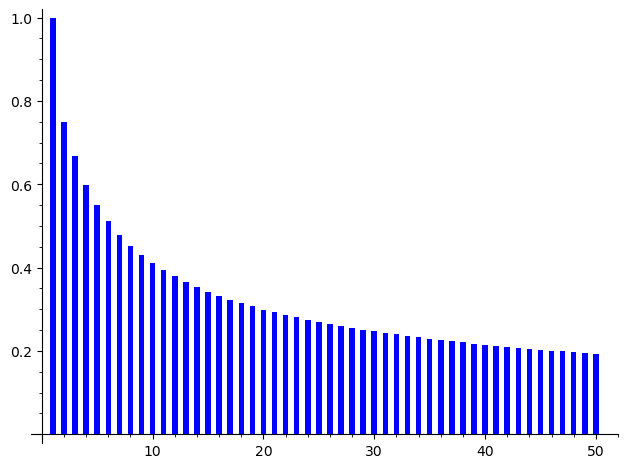

In [13]:
bar_chart([0]+[numerical_approx(PP(i).simplify()) for i in [1..50]])

Making the rounds
-----------------

In [14]:
s(n,x) = sum((2*j+1)/(1+x^(2*j+1)),j,0,n)
s

(n, x) |--> sum((2*j + 1)/(x^(2*j + 1) + 1), j, 0, n)

In [15]:
[(n,numerical_approx(s(n,e^pi).simplify())) for n in [5,10,50,100,500]]

[(5, 0.0416666666666667),
 (10, 0.0416666666666667),
 (50, 0.0416666666666667),
 (100, 0.0416666666666667),
 (500, 0.0416666666666667)]

In [16]:
(41+2/3)/1000

1/24

In [17]:
[(n,numerical_approx((s(n,e^pi)-1/24).simplify())) for n in [50,100,500]]

[(50, 1.38777878078145e-17),
 (100, 1.38777878078145e-17),
 (500, 1.38777878078145e-17)]

It seems like it approaches a rational number, but how to prove it?

Turn $e^{(2k+1)\pi}$ into an infinite power series?

Combine pairs of terms?

Evaluating infinite subseries?

In [18]:
k = var('k')
s2(n,j,x) = sum(2/(x^(2*k+1)+1),k,j,n) - 1/(x^(2*j+1)+1)
s2

(n, j, x) |--> -1/(x^(2*j + 1) + 1) + 2*sum(1/(x^(2*k + 1) + 1), k, j, n)

In [19]:
s3(n,x) = sum(s2(n,j,x),j,0,n)
s3

(n, x) |--> sum((2*(x^(2*j + 1) + 1)*sum(1/(x^(2*k + 1) + 1), k, j, n) - 1)/(x^(2*j + 1) + 1), j, 0, n)

In [20]:
(s3(5,x) - s(5,x)).simplify_full()

0